In [48]:
import pandas as pd
from collections import defaultdict
import random
from sklearn.decomposition import TruncatedSVD
import numpy as np
import matplotlib.pyplot as plt


In [49]:
rte_data = pd.read_csv('rte.standardized.tsv', sep='\t')
rte_data['response'] = rte_data['response'].map({1: 1, 0: -1})
rte_data['gold'] = rte_data['gold'].map({1: 1, 0: -1})

gold_data = rte_data[['orig_id', 'gold']].drop_duplicates(subset=['orig_id']).reset_index(drop=True)

In [59]:
def subsample(data: pd.DataFrame, k: int):
    task_dict = defaultdict(list)
    for index, row in data.iterrows():
        task_dict[row['orig_id']].append(row)
    new_df = pd.DataFrame()
    for task_id in task_dict:
        new_df = pd.concat([new_df, pd.DataFrame(random.sample(task_dict[task_id], k))], ignore_index=True)
    new_df = new_df.sample(frac=1).reset_index(drop=True)
    return new_df

In [51]:
def majority_vote(data: pd.DataFrame):
    labels = {}
    for orig_id, group in data.groupby('orig_id'):
        response_counts = group['response'].value_counts()
        majority_response = response_counts.index[0]
        labels[orig_id] = int(majority_response)
    return labels

In [52]:
def em(data: pd.DataFrame):
    labels = majority_vote(data)
    prev_labels = {}
    while prev_labels != labels:
        prev_labels = labels.copy()
        worker_quality = defaultdict(int)
        for worker_id, group in data.groupby('!amt_worker_ids'):
            for index, row in group.iterrows():
                worker_quality[worker_id] += 1 if row['response'] == labels[row['orig_id']] else 0
            worker_quality[worker_id] /= len(group)
        for orig_id, group in data.groupby('orig_id'):
            labels[orig_id] = 0
            for index, row in group.iterrows():
                labels[orig_id] += worker_quality[row['!amt_worker_ids']] * row['response']
            if labels[orig_id] == 0:
                labels[orig_id] = random.choice([1, -1])
            else:
                labels[orig_id] = 1 if labels[orig_id] > 0 else -1
    return labels

In [77]:
def svd(data: pd.DataFrame):
    tasks = sorted(data['orig_id'].unique())
    workers = sorted(data['!amt_worker_ids'].unique())
    task_to_idx = {task: i for i, task in enumerate(tasks)}
    worker_to_idx = {worker: i for i, worker in enumerate(workers)}
    
    U = np.zeros((len(tasks), len(workers)))
    
    for _, row in data.iterrows():
        task_idx = task_to_idx[row['orig_id']]
        worker_idx = worker_to_idx[row['!amt_worker_ids']]
        U[task_idx, worker_idx] = row['response']
    
    svd = TruncatedSVD(n_components=1, random_state=42)
    svd.fit(U)
    
    u1 = svd.transform(U)[:, 0]
    v = svd.components_[0]
    
    v = v / np.linalg.norm(v)
    
    s = np.sign(v)
    sigma = 1 if np.dot(u1, svd.transform(U)[:, 0]) >= 0 else -1
    worker_qualities = sigma * s
    labels = {}
    for task_id in tasks:
        task_responses = data[data['orig_id'] == task_id]
        label_sum = 0
        for _, response in task_responses.iterrows():
            worker_idx = worker_to_idx[response['!amt_worker_ids']]
            label_sum += worker_qualities[worker_idx] * response['response']
        labels[task_id] = 1 if label_sum >= 0 else -1
    
    return labels

In [67]:
def run_experiment():
    gold_dict = dict(zip(gold_data['orig_id'], gold_data['gold']))

    majority_vote_errors = []
    em_errors = []
    svd_errors = []
    for i in range(1, 11):
        data = subsample(rte_data, i)
        
        majority_vote_labels = majority_vote(data)
        majority_vote_errors.append(sum(majority_vote_labels[task_id] != gold_dict[task_id] 
                                      for task_id in majority_vote_labels) / len(majority_vote_labels))
        
        em_labels = em(data)
        em_errors.append(sum(em_labels[task_id] != gold_dict[task_id] 
                           for task_id in em_labels) / len(em_labels))
        
        svd_labels = svd(data)
        svd_errors.append(sum(svd_labels[task_id] != gold_dict[task_id] 
                            for task_id in svd_labels) / len(svd_labels))
        
    return majority_vote_errors, em_errors, svd_errors

[0.263   0.2695  0.19    0.204   0.1575  0.1565  0.1245  0.125   0.10475
 0.102  ]
[0.263   0.24075 0.19    0.137   0.15725 0.10325 0.11225 0.0925  0.088
 0.07775]
[0.48525 0.46725 0.501   0.46925 0.479   0.48925 0.49325 0.503   0.48975
 0.49375]


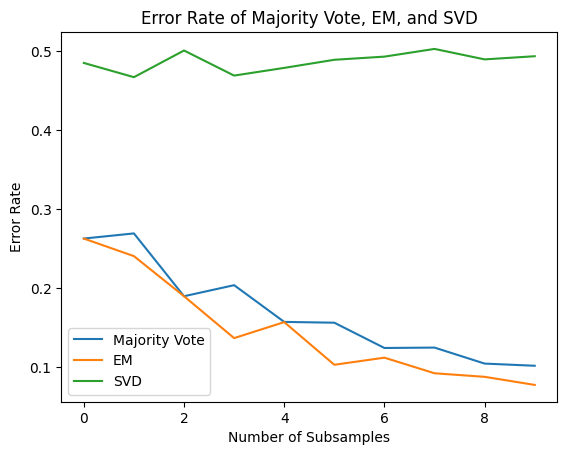

In [110]:
agg_majority_vote_errors = []
agg_em_errors = []
agg_svd_errors = []
for i in range(5):
    majority_vote_errors, em_errors, svd_errors = run_experiment()
    agg_majority_vote_errors.append(majority_vote_errors)
    agg_em_errors.append(em_errors)
    agg_svd_errors.append(svd_errors)
agg_majority_vote_errors = np.mean(agg_majority_vote_errors, axis=0)
agg_em_errors = np.mean(agg_em_errors, axis=0)
agg_svd_errors = np.mean(agg_svd_errors, axis=0)
print(agg_majority_vote_errors)
print(agg_em_errors)
print(agg_svd_errors)

plt.plot(agg_majority_vote_errors, label='Majority Vote')
plt.plot(agg_em_errors, label='EM')
plt.plot(agg_svd_errors, label='SVD')
plt.xlabel('Number of Subsamples')
plt.ylabel('Error Rate')
plt.title('Error Rate of Majority Vote, EM, and SVD')
plt.legend()
plt.show()

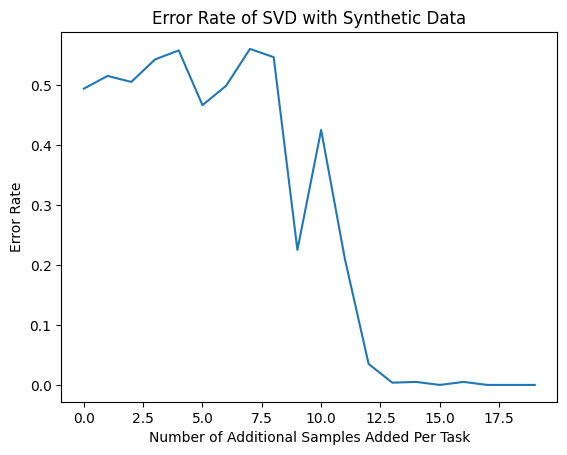

In [109]:
def calculate_worker_accuracies(data: pd.DataFrame, gold_dict: dict) -> dict:
    worker_accuracies = {}
    for worker_id, group in data.groupby('!amt_worker_ids'):
        correct = sum(row['response'] == gold_dict[row['orig_id']] for _, row in group.iterrows())
        worker_accuracies[worker_id] = correct / len(group)
    return worker_accuracies

def generate_synthetic_responses(data: pd.DataFrame, k: int, worker_accuracies: dict, gold_dict: dict) -> pd.DataFrame:
    tasks = data['orig_id'].unique()
    workers = list(worker_accuracies.keys())
    
    synthetic_data = []
    for task_id in tasks:
        task_workers = random.sample(workers, k)
        true_label = gold_dict[task_id]
        
        for worker_id in task_workers:
            if random.random() < worker_accuracies[worker_id]:
                response = true_label
            else:
                response = -true_label
                
            synthetic_data.append({
                'orig_id': task_id,
                '!amt_worker_ids': worker_id,
                'response': response
            })
    
    combined_data = pd.concat([data, pd.DataFrame(synthetic_data)], ignore_index=True)
    return combined_data.sample(frac=1).reset_index(drop=True)

def svd_synthetic(k: int = 30):
    gold_dict = dict(zip(gold_data['orig_id'], gold_data['gold']))
    worker_accuracies = calculate_worker_accuracies(rte_data, gold_dict)

    data = generate_synthetic_responses(rte_data, k, worker_accuracies, gold_dict)
    
    svd_labels = svd(data)
    return sum(svd_labels[task_id] != gold_dict[task_id] for task_id in svd_labels) / len(svd_labels)

errors = []
for i in range(20):
    errors.append(svd_synthetic(i))
plt.plot(errors)
plt.xlabel('Number of Additional Samples Added Per Task')
plt.ylabel('Error Rate')
plt.title('Error Rate of SVD with Synthetic Data')
plt.show()